In [1]:
import numpy as np

In [30]:
url="http://physics.muni.cz/~munz/astro/gbm/200412381/det%i.npz"
def fetch(url):
    import requests
    from io import BytesIO

    ff=requests.get(url, stream = True)
    return np.load(BytesIO(ff.raw.read()))
    
allfls=[fetch(url%i) for i in range(6,10)]

In [34]:
alldat=[f['time'] for f in allfls]

<ipython-input-20-b3eb76923b2b>:5: RuntimeWarning: divide by zero encountered in log
  pl.hist(np.log((tm[1:]-tm[:-1])),np.r_[-15:-5:20j]);


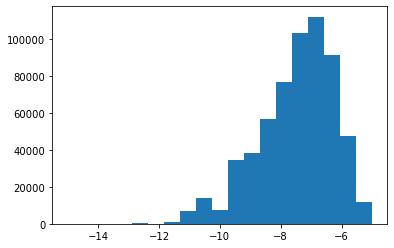

In [20]:
tm=data['time']
import matplotlib.pyplot as pl
%matplotlib inline

pl.hist(np.log((tm[1:]-tm[:-1])),np.r_[-15:-5:20j]);

In [38]:
tmax=140
allrang={}
for i in range(4):#6,10):
    #alldat[i]=np.load("det%i.npz"%i)['time']
    qr=np.arange(len(alldat[i]))
    allrang[i]=[qr[alldat[i]>=tmax-40][0],qr[alldat[i]>=tmax+40][0]]
from evlist_corr import *

In [47]:
qmid,qsiz=34,12
qful=2*qmid
cent=(qmid-qsiz)*fac

def onetest(ev1,ev2,fac,tstart=110,do_fit=True,tshift=0):
    bin1,cur1=lcurve(ev1,fac,-2*fac,tstart=tstart)
    bin2,cur2=lcurve(ev2,fac,-2*fac,tstart=tstart)
    nor1,nor2=1/cur1.sum(),1/cur2.sum()
    cwin1=cur1[(qmid-qsiz)*fac:(qmid+qsiz)*fac]
    cwin2=cur2[:qful*fac]
    cfunc=np.correlate(cwin1*nor1,cwin2*nor2,"valid")
    if do_fit:
        try:
            res=[fit_corr(cfunc,doplot=False,inifac=fac/100,cmax=cent)[0]-cent]
        except:
            res=[0]
    else:
        res=[0]
    res+=list(wcent(cfunc,nbin=5)-cent-tshift*fac)
    res+=[cfunc.max(),cwin1.max(),cwin2.max(),np.argmax(cwin1),np.argmax(cwin2)]
    return res

def multest(tevs,tevs2,niter=50,fac=50,subsam=10,nshi=10,nshi2=0,randomize=True,do_fit=False):
    #selecting every subsam event
    #shifting wrt. binning
    cent=(qmid-qsiz)*fac
    
    gres2=[]
    if randomize:
        for m in range(niter):
            ev1=tevs[randids(z0,z1,subsam)]
            ev2=tevs2[randids(z20,z21,subsam)]
            for dt in np.r_[0:1./fac:nshi*1j]:
                if nshi2>0:
                    for dt2 in np.r_[0:1./fac:nshi2*1j]:
                        gres2.append(onetest(ev1+dt,ev2+dt2,fac,do_fit=do_fit,tshift=dt2-dt))
                else:
                    gres2.append(onetest(ev1+dt,ev2+dt,fac,do_fit=do_fit))
    else:
        for k in range(subsam):
            for l in range(subsam):
                sel2=slice(z0+k,z1,subsam)
                sel22=slice(z20+l,z21,subsam)
                gres2.append(onetest(tevs[sel2]+dt,tevs2[sel22]+dt,fac,do_fit=do_fit))         
    return np.array(gres2)

#[np.std(np.median(gres2[:,i].reshape(nshi,subsam**2),0))/fac*1e3 for i in range(0,5)]

i,j=2,3
fac=50
nshi=20
tevs,tevs2=alldat[i],alldat[j]
z0,z1=allrang[i]#,alldat[j]#qr[tevs>=tmax-40][0],qr[tevs>=tmax+40][0]
z20,z21=allrang[j]
#gres2=multest(tevs,tevs2,fac=fac,nshi=nshi)

[np.std(np.median(gres2[:,i].reshape(len(gres2)//nshi,nshi),1))/fac*1e3 for i in range(1,5)]

[3.193243642175039, 6.526436585100783, 9.17053281704443, 13.331894785869336]

#### test suite 2

- shifting both lightcurves by a fraction of time bin
- is final histogram normal? (test from `scipy.stats`)

try to clip out outliers and then fit remaining set with (truncated) normal PDF 

In [50]:
nshi=10
gres22=multest(tevs,tevs2,50,fac=fac,nshi=nshi,nshi2=nshi)

[np.std(np.median(gres22[:,i].reshape(len(gres22)//(nshi**2),nshi**2),1))/fac*1e3 for i in range(1,5)]

[3.362258529351444, 7.2180729569824145, 10.30056577162719, 14.947980328529544]

In [193]:
def clipperc(st,ran=[10,90]):
    low,hig=np.percentile(st,ran)
    return st[(st>=low)*(st<hig)]

from evlist_corr import tcdf

(array([ 6., 10., 13., 19.,  9., 19., 10.,  5.,  7.,  2.]),
 array([-1.52158738, -1.30685507, -1.09212276, -0.87739045, -0.66265814,
        -0.44792583, -0.23319352, -0.01846122,  0.19627109,  0.4110034 ,
         0.62573571]),
 <a list of 10 Patch objects>)

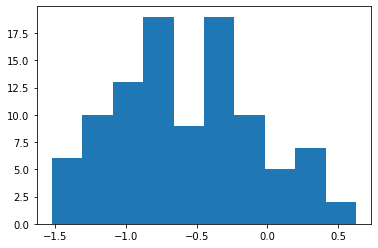

In [51]:
podet=gres22[:,1].reshape(len(gres22)//nshi**2,nshi**2)
from scipy import stats as st
pores=st.normaltest(podet,axis=1)

podet2=gres22[:,2].reshape(len(gres22)//nshi**2,nshi**2)
pores2=st.normaltest(podet2,axis=1)

pl.hist(podet[3])

In [177]:
from scipy import optimize as op
samp1=[]
for dis in podet:
    psel=clipperc(dis)
    minq2=lambda p:st.kstest(psel,lambda z:tcdf(z,p)).statistic
    bfit2=op.fmin(minq2,[psel.mean(),psel.std()],disp=0)
    samp1.append(list(bfit2)+[minq2(bfit2)])
samp1=np.array(samp1).T

3.3658340606932384

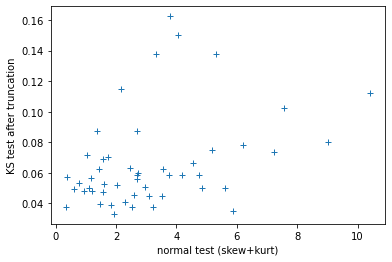

In [187]:
pl.plot(pores.statistic,samp1[2],'+')
pl.xlabel("normal test (skew+kurt)")
pl.ylabel("KS test after truncation")
samp1[0].std()/fac*1e3

7.279154418942038

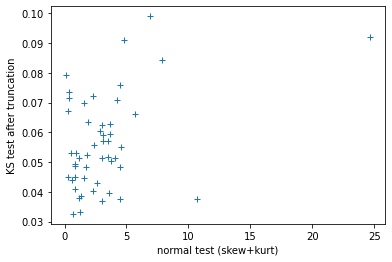

In [188]:
#same thing with weighted average of larger interval
samp2=[]
for dis in podet2:
    psel=clipperc(dis)
    minq2=lambda p:st.kstest(psel,lambda z:tcdf(z,p)).statistic
    bfit2=op.fmin(minq2,[psel.mean(),psel.std()],disp=0)
    samp2.append(list(bfit2)+[minq2(bfit2)])
samp2=np.array(samp2).T
pl.plot(pores2.statistic,samp2[2],'+')
pl.xlabel("normal test (skew+kurt)")
pl.ylabel("KS test after truncation")
samp2[0].std()/fac*1e3

### Appendix: CDF tests

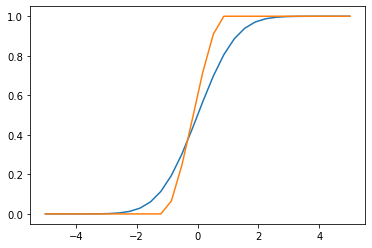

In [145]:
## how to make truncated cdf
x=np.r_[-5:5:30j]
pc=[0.1,0.9]
zfun=lambda z:(st.norm(*pf).cdf(z)-pc[0])/(pc[1]-pc[0])
zcun=lambda z:min(max(zfun(z),0),1)
pl.plot(x,st.norm.cdf(x))
pl.plot(x,[zcun(p) for p in x])

In [153]:
minq1=lambda p:st.kstest(cpk1,st.norm(p[0],p[1]).cdf).statistic
bfit=op.fmin(minq1,[0,1],disp=0)
bfit,minq1(bfit)

def tcdf(z,pf,pc=[0.1,0.9]):
    #truncated normal CDF
    vals=(st.norm(pf[0],pf[1]).cdf(z)-pc[0])/(pc[1]-pc[0])
    if np.iterable(vals):
        vals[vals<0]=0
        vals[vals>1]=1
    return vals
#minq2=lambda p:st.kstest(cpk1,lambda z:min(max((st.norm(*p).cdf(z)-pc[0])/(pc[1]-pc[0]),0),1)).statistic
minq2=lambda p:st.kstest(cpk1,lambda z:tcdf(z,p)).statistic
bfit2=op.fmin(minq2,bfit,disp=0)
bfit,bfit2,minq1(bfit2)

(array([1.2141167 , 1.62215151]),
 array([1.21753312, 2.2364743 ]),
 0.1330814871632396)

In [166]:
mtest2=[]
for i in range(100):
    pkx=st.norm(1,2).rvs(size=100)
    cpkx=clipperc(pkx,[10,90])
    minq1=lambda p:st.kstest(cpkx,st.norm(p[0],p[1]).cdf).statistic
    bfit=op.fmin(minq1,[1,2],disp=0)
    minq2=lambda p:st.kstest(cpkx,lambda z:tcdf(z,p)).statistic
    bfit2=op.fmin(minq2,bfit,disp=0)
    mtest2.append(list(bfit)+list(bfit2)+[minq1(bfit),minq2(bfit2)]+[pkx.mean(),pkx.std()])

In [141]:
pf=[-0.14383523,  0.69971898]
st.kstest(cpk1,lambda x:st.norm(pf[0],pf[1]).cdf(2*x))

KstestResult(statistic=0.20836212346269456, pvalue=0.0015921638912524242)

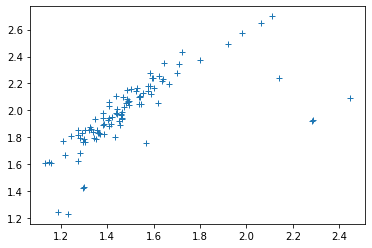

In [162]:
mtest=np.array(mtest)
pl.plot(mtest[:,1],mtest[:,3],'+')

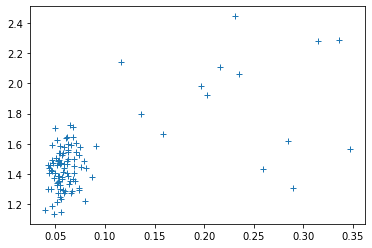

In [171]:
pl.plot(mtest[:,4],mtest[:,1],'+')

In [170]:
mtest.mean(0),mtest2.mean(0)

(array([0.87363377, 1.49499521, 0.92769415, 1.9853877 , 0.08400564,
        0.0699028 ]),
 array([0.96997191, 1.40160593, 0.97092155, 1.89393976, 0.05885617,
        0.06294773, 0.97669196, 1.96932715]))

In [169]:
mtest2=np.array(mtest2)
mtest.std(0),mtest2.std(0)

(array([0.3961589 , 0.24016035, 0.3445183 , 0.25360267, 0.06781201,
        0.04618328]),
 array([0.2014131 , 0.14060999, 0.19988178, 0.24759844, 0.01143134,
        0.024028  , 0.19290496, 0.13028007]))